In [1]:
SEED = 0
cores = 16

from numpy.random import seed
seed(SEED)
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from collections import Counter
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
from xgboost import plot_importance
from matplotlib import pyplot as plt
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import classification_report
import shap
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
import joblib

# version check
import sys
print("python version")
print(sys.version)
import sklearn
print("sklearn version = ", sklearn.__version__)
print("numpy version = ", np.__version__)
print("pandas version =", pd.__version__)

python version
3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
sklearn version =  0.23.2
numpy version =  1.19.2
pandas version = 1.2.3


In [2]:
df = pd.read_csv("~/proj_ua/data/ua_full_10types_new.v7.csv", dtype={'id':str})
df2 = df[(df['from']=="cha") & (df['age']>=18) & (df['age']<=90)]
df2['eGFR_ab45'] = np.where(df2['eGFR_ckd']<45,1,0)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [3]:
#3group age split  

##step 1 finding edge value
abnormal_disc = df2.query('eGFR_ab45==1').loc[:,'age']
abnormal_disc = pd.DataFrame(abnormal_disc)

est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')
est.fit(abnormal_disc)

ab_disc = est.transform(abnormal_disc).astype('float')
print("edges : ", est.bin_edges_[0])

age0_edge = est.bin_edges_[0][1]
age1_edge = est.bin_edges_[0][2]
age2_edge = est.bin_edges_[0][3]
print('age0_edge:', age0_edge, '\nage1_edge:', age1_edge, '\nage2_edge:', age2_edge)

abnormal_disc['level'] = abnormal_disc.apply(lambda x : 0 if x['age']<age0_edge else 1 if x['age']<age1_edge else 2, axis=1)
print('age group:\n',abnormal_disc['level'].value_counts().sort_index())

edges :  [18.         50.91879412 69.93915802 90.        ]
age0_edge: 50.91879411967486 
age1_edge: 69.9391580177803 
age2_edge: 90.0
age group:
 0     723
1    1966
2    3234
Name: level, dtype: int64


In [4]:
##make 3group by age
df3 = df2.copy()

#age0_edge, age1_edge = 60, 75
##age cut set up
df3['level'] = df3.apply(lambda x : 0 if x['age']<age0_edge else 1 if x['age']<age1_edge else 2, axis=1)
print(df3['level'].value_counts())

0    132883
1     56994
2     20985
Name: level, dtype: int64


In [5]:
##age0 group
X_age0 = df3[df3['level']==0]
y_age0 = X_age0['eGFR_ab45'].astype("int64")

print('\nage0', X_age0['age'].min(), X_age0['age'].max())
print("total cases = %d" %X_age0.shape[0])
print("total abnormal function of kidney = %d" %sum(y_age0), "\nprevalence =", sum(y_age0)/len(y_age0)*100)

X_train0, X_test0, y_train0, y_test0 = train_test_split(X_age0, y_age0, test_size=0.2, stratify=y_age0, random_state=SEED)
print("train0 : %d" % sum(y_train0), "test0 : %d" % sum(y_test0))

##age1 group
X_age1 = df3[df3['level']==1]
y_age1 = X_age1['eGFR_ab45']

print('\nage1', X_age1['age'].min(), X_age1['age'].max())
print("total cases = %d" %X_age1.shape[0])
print("total abnormal function of kidney = %d" %sum(y_age1), "\nprevalence =", sum(y_age1)/len(y_age1)*100)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_age1, y_age1, test_size=0.2, stratify=y_age1, random_state=SEED)
print("train1 : %d" % sum(y_train1), "test0 : %d" % sum(y_test1))

##age2 group
X_age2 = df3[df3['level']==2]
y_age2 = X_age2['eGFR_ab45']

print('\nage2', X_age2['age'].min(), X_age2['age'].max())
print("total cases = %d" %X_age2.shape[0])
print("total abnormal function of kidney = %d" %sum(y_age2), "\nprevalence =", sum(y_age2)/len(y_age2)*100)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_age2, y_age2, test_size=0.2, stratify=y_age2, random_state=SEED)
print("train2 : %d" % sum(y_train2), "test2 : %d" % sum(y_test2))


age0 18 50
total cases = 132883
total abnormal function of kidney = 723 
prevalence = 0.5440876560583371
train0 : 578 test0 : 145

age1 51 69
total cases = 56994
total abnormal function of kidney = 1966 
prevalence = 3.4494859107976277
train1 : 1573 test0 : 393

age2 70 90
total cases = 20985
total abnormal function of kidney = 3234 
prevalence = 15.411007862759114
train2 : 2587 test2 : 647


In [6]:
##concat both trainset and testset
X_train = pd.concat([X_train0, X_train1, X_train2])
y_train = pd.concat([y_train0, y_train1, y_train2])

X_test = pd.concat([X_test0, X_test1, X_test2])
y_test = pd.concat([y_test0, y_test1, y_test2])

print("total cases = %d" % (X_train.shape[0] + X_test.shape[0]))
print("total abnormal function of kidney = %d" % (sum(y_train) + sum(y_test)), "\nprevalence =", (sum(y_train)+sum(y_test))/(len(y_train)+len(y_test))*100)

total cases = 210862
total abnormal function of kidney = 5923 
prevalence = 2.8089461353871252


In [7]:
X_train_features = X_train.loc[:, 'male':'leucocyte']

print('%d train cases, %d variables' % (X_train_features.shape[0], X_train_features.shape[1]))
print('%d test cases'%X_test.shape[0])

168689 train cases, 12 variables
42173 test cases


In [8]:
#standardization

scaler = StandardScaler()
std_cols=['age','he_uph','he_usg']
std_df=X_train_features[std_cols]

X_train_features[std_cols]=scaler.fit_transform(std_df)
X_train_features.describe()

,male,age,he_uph,he_unitr,he_usg,he_upro,he_uglu,he_uket,he_ubil,he_ubld,he_uro,leucocyte
count,168689.000000,1.686890e+05,1.686890e+05,168689.000000,1.686890e+05,168689.000000,168689.000000,168689.000000,168689.000000,168689.000000,168689.000000,168689.000000
mean,0.421332,-5.391547e-17,-1.145704e-16,0.019835,1.648803e-14,0.326749,0.198288,0.201299,0.037412,0.772404,0.126772,0.511717
std,0.493774,1.000003e+00,1.000003e+00,0.139435,1.000003e+00,0.763357,0.821801,0.664694,0.319771,1.262495,0.528855,1.021307
min,0.000000,-1.851626e+00,-1.472512e+00,0.000000,-1.721268e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-7.550769e-01,-8.614876e-01,0.000000,-1.089549e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,-1.745511e-01,-2.504637e-01,0.000000,1.738895e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,7.284891e-01,9.715841e-01,0.000000,8.056085e-01,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,2.792581e+00,3.415680e+00,1.000000,1.437328e+00,5.000000,5.000000,5.000000,4.000000,5.000000,4.000000,4.000000


In [9]:
# scalre save
scaler = StandardScaler()
scaler.fit(std_df)
joblib.dump(scaler, '/home/danssa/proj_ua/shared/scaler45.pkl')

['/home/danssa/proj_ua/shared/scaler45.pkl']

In [10]:
#model fit and mean accuracy
def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=8, random_state=SEED)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=cores)
    return scores

#model : ua_cha45_10types.v5
model = XGBClassifier(colsample_bytree=0.8, gamma=0.6, learning_rate=0.01, max_depth=3, 
                          min_child_weight=1, n_estimators=750, objective="binary:logistic",
                          reg_alpha=0.5, reg_lambda=8, scale_pos_weight=35, subsample=0.8, 
                          nthread=6, random_state=SEED).fit(X_train_features, y_train)
scores = evaluate_model(X_train_features, y_train, model)
print('Mean accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean accuracy: 0.953 (0.002)


In [11]:
# new model 

## new trainset
X_train_features_new = X_train_features.loc[:, ['male', 'he_usg', 'he_uph', 'he_ubld', 'he_uglu', 'he_upro', 'age']]

## model fit
model_new = XGBClassifier(colsample_bytree=0.8, gamma=0.6, learning_rate=0.01, max_depth=3, 
                          min_child_weight=1, n_estimators=750, objective="binary:logistic",
                          reg_alpha=0.5, reg_lambda=8, scale_pos_weight=35, subsample=0.8, 
                          nthread=6, random_state=SEED).fit(X_train_features_new, y_train)
scores_new = evaluate_model(X_train_features_new, y_train, model)
print('Mean AUC of new model : %.3f (%.3f)' % (mean(scores_new), std(scores_new)))

Mean AUC of new model : 0.952 (0.002)


In [24]:
## model save
joblib.dump(model_new, "/home/danssa/proj_ua/shared/ua45_model")
load_model = joblib.load('ua45_model')

In [25]:
#testset proteinuria
X_test_features = X_test.loc[:, ['male', 'he_usg', 'he_uph', 'he_ubld', 'he_uglu', 'he_upro', 'age']]
std_df=X_test_features[std_cols]
X_test_features[std_cols]=scaler.transform(std_df)

#testset non proteinuria
X_test_non = X_test.query('he_upro<2')
X_test_features_non = X_test_non.loc[:, ['male', 'he_usg', 'he_uph', 'he_ubld', 'he_uglu', 'he_upro', 'age']]
std_df_non=X_test_features_non[std_cols]
X_test_features_non[std_cols]=scaler.transform(std_df_non)

#testset proteinuria
X_test_pro = X_test.query('he_upro>=2')
X_test_features_pro = X_test_pro.loc[:, ['male', 'he_usg', 'he_uph', 'he_ubld', 'he_uglu', 'he_upro', 'age']]
std_df_pro=X_test_features_pro[std_cols]
X_test_features_pro[std_cols]=scaler.transform(std_df_pro)

In [26]:
# make sample df

## non-proteinuria
df_non_sample = resample(X_test_non, n_samples=2000, replace=False, stratify=X_test_non['eGFR_ab45'], random_state=0)
df_non_sample = df_non_sample.drop(['from','level','leucocyte','eGFR_ab45','id'], axis=1)
df_non_sample['eGFR_ab45'] = np.where(df_non_sample['eGFR_ckd']<45,1,0)
df_non_sample.to_csv('/home/danssa/proj_ua/shared/sample45_non.csv', index=False)

## proteinuria
df_pro_sample = resample(X_test_pro, n_samples=2000, replace=False, stratify=X_test_pro['eGFR_ab45'], random_state=0)
df_pro_sample = df_pro_sample.drop(['from','level','leucocyte','eGFR_ab45','id'], axis=1)
df_pro_sample['eGFR_ab45'] = np.where(df_pro_sample['eGFR_ckd']<45,1,0)
df_pro_sample.to_csv('/home/danssa/proj_ua/shared/sample45_pro.csv', index=False)

In [27]:
# load sample df

sample_non = pd.read_csv('sample45_non.csv')
sample_pro = pd.read_csv('sample45_pro.csv')

In [28]:
#standardization columns
std_cols=['age','he_uph','he_usg']

#testset non proteinuria
X_test_non = sample_non
X_test_features_non = X_test_non.loc[:, ['male', 'he_usg', 'he_uph', 'he_ubld', 'he_uglu', 'he_upro', 'age']]
std_df_non=X_test_features_non[std_cols]
X_test_features_non[std_cols]=scaler.transform(std_df_non)
y_test_non = sample_non['eGFR_ab45']

#testset proteinuria
X_test_pro = sample_pro
X_test_features_pro = X_test_pro.loc[:, ['male', 'he_usg', 'he_uph', 'he_ubld', 'he_uglu', 'he_upro', 'age']]
std_df_pro=X_test_features_pro[std_cols]
X_test_features_pro[std_cols]=scaler.transform(std_df_pro)
y_test_pro = sample_pro['eGFR_ab45']

Non-proteinuria

Classification Report

Best Threshold=0.291, sensitivity = 1.00, specificity = 0.82, J=0.823
              precision    recall  f1-score   support

      normal       1.00      0.82      0.90      1971
    abnormal       0.08      1.00      0.14        29

    accuracy                           0.83      2000
   macro avg       0.54      0.91      0.52      2000
weighted avg       0.99      0.83      0.89      2000



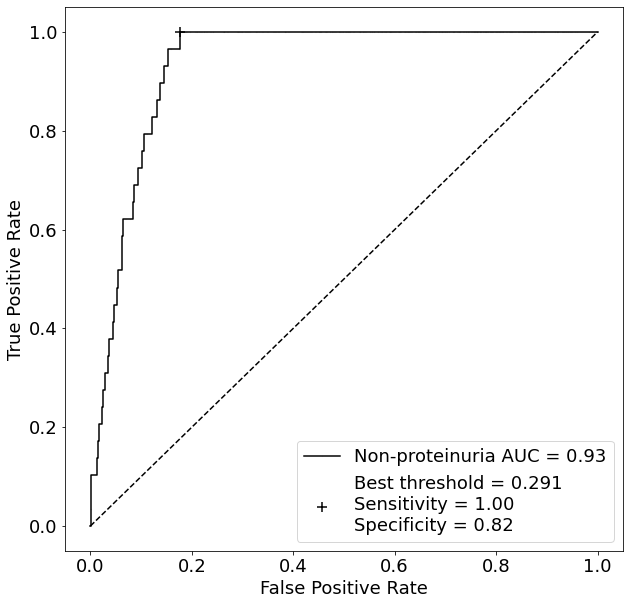

In [29]:
#non proteinuria

#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob_non = load_model.predict_proba(X_test_features_non)[:,1]

# calculate roc curves
fpr_non, tpr_non, thresholds_non = roc_curve(y_test_non, y_prob_non)
# get the best threshold
J_non = tpr_non - fpr_non
ix_non = argmax(J_non)
best_thresh_non = thresholds_non[ix_non]

print('Non-proteinuria')
print('\nClassification Report\n')
print('Best Threshold=%.3f, sensitivity = %.2f, specificity = %.2f, J=%.3f' % (best_thresh_non, tpr_non[ix_non], 1-fpr_non[ix_non], J_non[ix_non]))

y_prob_pred_non = (y_prob_non >= best_thresh_non).astype(bool)
print(classification_report(y_test_non, y_prob_pred_non, target_names=['normal', 'abnormal']))

#plot roc and best threshold
sens_non, spec_non = tpr_non[ix_non], 1-fpr_non[ix_non]
# plot the roc curve for the model
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["font.size"] = 18
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')
plt.plot(fpr_non, tpr_non, marker='.', color='black', markersize=0.05, label="Non-proteinuria AUC = %.2f" % roc_auc_score(y_test_non, y_prob_non))
plt.scatter(fpr_non[ix_non], tpr_non[ix_non], marker='+', s=100, color='k', 
            label='Best threshold = %.3f \nSensitivity = %.2f \nSpecificity = %.2f' % (best_thresh_non, sens_non, spec_non))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)

# show the plot
plt.show()

Proteinuria

Classification Report

Best Threshold=0.826, sensitivity = 0.90, specificity = 0.75, J=0.647
              precision    recall  f1-score   support

      normal       0.97      0.75      0.84      1652
    abnormal       0.43      0.90      0.58       348

    accuracy                           0.77      2000
   macro avg       0.70      0.82      0.71      2000
weighted avg       0.88      0.77      0.80      2000



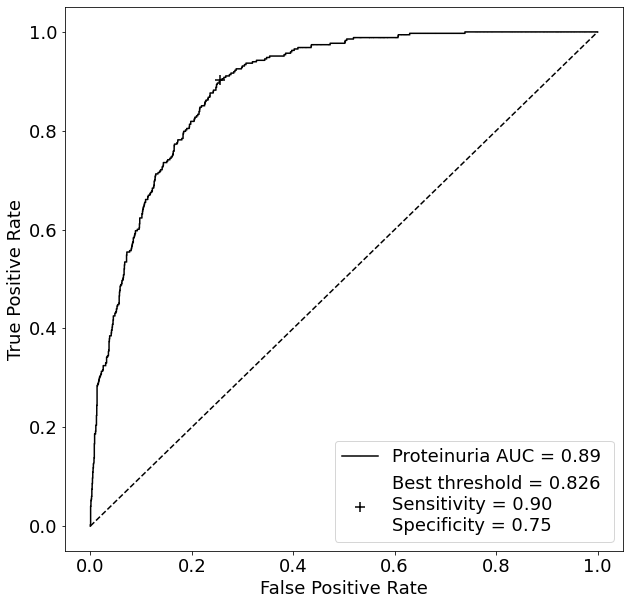

In [30]:
#proteinuria

#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob_pro = load_model.predict_proba(X_test_features_pro)[:,1]

# calculate roc curves
fpr_pro, tpr_pro, thresholds_pro = roc_curve(y_test_pro, y_prob_pro)
# get the best threshold
J_pro = tpr_pro - fpr_pro
ix_pro = argmax(J_pro)
best_thresh_pro = thresholds_pro[ix_pro]

print('Proteinuria')
print('\nClassification Report\n')
print('Best Threshold=%.3f, sensitivity = %.2f, specificity = %.2f, J=%.3f' % (best_thresh_pro, tpr_pro[ix_pro], 1-fpr_pro[ix_pro], J_pro[ix_pro]))

y_prob_pred_pro = (y_prob_pro >= best_thresh_pro).astype(bool)
print(classification_report(y_test_pro, y_prob_pred_pro, target_names=['normal', 'abnormal']))

#plot roc and best threshold
sens_pro, spec_pro = tpr_pro[ix_pro], 1-fpr_pro[ix_pro]
# plot the roc curve for the model
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["font.size"] = 18
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')
plt.plot(fpr_pro, tpr_pro, marker='.', color='black', markersize=0.05, label="Proteinuria AUC = %.2f" % roc_auc_score(y_test_pro, y_prob_pro))
plt.scatter(fpr_pro[ix_pro], tpr_pro[ix_pro], marker='+', s=100, color='k', 
            label='Best threshold = %.3f \nSensitivity = %.2f \nSpecificity = %.2f' % (best_thresh_pro, sens_pro, spec_pro))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)

# show the plot
plt.show()